# Исследование поездок на самокате пользователей из разных городов

Нам передали данные сервиса аренды самокатов GoFast — информацию о пользователях из нескольких городов, их поездках, ниличии подписки. Необходимо проанализировать полученные данные и проверить гипотезы, которые могут помочь бизнесу вырасти. Нужно проанализировать данные о пользователях с подпиской и без, и выяснить, действительно ли пользователи с платной подпиской приносят бизнесу более высокую прибыль.

Для анализа у нас есть три набора данных: о пользователях, их поездках и подписках.

Для выполнения этой задачи в данном проекте нужно выполнить несколько шагов: 
1. необходимо проанализировать датафреймы, изучить общую информацию и найти проблемные места в данных;
2. произвести предобработку данных -  устранить найденные в них ошибки и неточности;
3. произвести исследовательский анализ - проанализировать основные факторы, котрые имеют влияние на месячную выручку сервиса, и как они отличаются для пользователей с платной подпиской и без;
4. создать новые датафреймы, которые помогут нам в решении поставленной задачи;
5. рассчитать среднемесячную выручку по месяцам;
6. проверить выдвинутые гипотезы;
7. помочь отделу маркетинга с решением задач для продвижения сервиса; 
8. сделать выводы по полученным результатам.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import binom
from math import sqrt

#### Шаг 2. Предобработка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
display(users.head())
rides = pd.read_csv('/datasets/rides_go.csv')
display(rides.head())
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
display(subscriptions.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [5]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [6]:
#найдём количество дубликатов
dataframes = {'users': users, 'rides': rides, 'subscriptions': subscriptions}

for name, df in dataframes.items():
    print(f'Количество явных дубликатов в датафрейме {name}:', df.duplicated().sum())
#print ('Количество явных дубликатов в первом датафрейме:', users.duplicated().sum())
#print('Количество явных дубликатов во втором датафрейме:', rides.duplicated().sum())
#print('Количество явных дубликатов в третьем датафрейме:', subscriptions.duplicated().sum())

Количество явных дубликатов в датафрейме users: 31
Количество явных дубликатов в датафрейме rides: 0
Количество явных дубликатов в датафрейме subscriptions: 0


In [7]:
#plt.figure(figsize=(10, 5))
#subscriptions.hist();

# ***Вывод:***

В первом датафрейме **users** представлены данные о пользователях: их идентификационном номере, имени, возрасте, городе и типе подписки.
В датафрейме 1565 строк и 5 столбцов, ни в одном столбце нет пропущенных значений. В датефрейме присутствует 31 явный дубликат.

Во втром датафрейме **rides** представлена информация о поездках: идентификационный номер пользователя, расстояние, длительность поездок и их даты.
В датефрейме 18068 строк, 4 столбца. Ни в одном из столбцов нет пропущенных значений. Явных дубликатов нет. При анализе гистограммы можно сказать, что в столбце 'duration' могут быть аномальные значения.

В третьем датафрейме **subscriptions** содержится информация о подписке: есть ли она у пользователя или нет, сколько стоит подписка, сколько стоит минута поездки с подпиской и без, и сколько стоит начало поезки с подпиской и без. 
В датафрейме 2 строки и 4 столбца. Пропусков и явных дубликатов в датафрейме нет.

#### Шаг 2. Предобработка данных

##### Приведём данные к правильному типу и округлим значения

In [8]:
# приведём столбец к правильному типу
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%dT%H:%M:%S')

In [9]:
rides['distance'] = rides['distance'].round(2)
rides['duration'] = rides['duration'].round(2)
#rides['duration'] = np.ceil(rides['duration'])

In [10]:
# добавим новый столбец в датафрейм rides
rides['month'] = rides['date'].dt.month

##### Работа с дубликатами

Ранее мы выяснили, что в датафрейме users у нас присутствует 31 дубликат.  
С помощью метода drop_duplicates() избавимся от явных дубликатов в датафрейме.

In [11]:
users = users.drop_duplicates()

In [12]:
# проверим произведённые изменения
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


In [13]:
print ('Количество явных дубликатов в первом датафрейме:', users.duplicated().sum())

Количество явных дубликатов в первом датафрейме: 0


После удаления дубликатов в датафрейме осталось 1534 строки. Явных дубликатов не осталось.  
В двух других датафреймах дубликатов не было.  
Пропущенных значений в датафреймах нет.

##### Проверка на неявные дубликаты

Проверим столбцы, где возможно обнаружить неявные дубликаты:

In [14]:
print(users['name'].sort_values().unique())

['Агата' 'Аделина' 'Адель' 'Айдар' 'Александр' 'Александра' 'Алексей'
 'Алина' 'Алиса' 'Алия' 'Алла' 'Альберт' 'Альбина' 'Алёна' 'Амалия'
 'Амина' 'Амир' 'Анастасия' 'Анатолий' 'Ангелина' 'Андрей' 'Анжелика'
 'Анна' 'Антон' 'Антонина' 'Ариана' 'Арина' 'Арсен' 'Арсений' 'Артемий'
 'Артур' 'Артём' 'Богдан' 'Борис' 'Вадим' 'Валентина' 'Валерий' 'Валерия'
 'Варвара' 'Василий' 'Василина' 'Василиса' 'Вера' 'Вероника' 'Виктор'
 'Виктория' 'Виолетта' 'Виталий' 'Виталина' 'Влад' 'Влада' 'Владимир'
 'Владислав' 'Владислава' 'Всеволод' 'Вячеслав' 'Галина' 'Георгий'
 'Герман' 'Глеб' 'Гордей' 'Григорий' 'Давид' 'Дамир' 'Даниил' 'Данил'
 'Данила' 'Даниэль' 'Дарина' 'Дарья' 'Демид' 'Денис' 'Диана' 'Дмитрий'
 'Ева' 'Евгений' 'Евгения' 'Егор' 'Екатерина' 'Елена' 'Елизавета' 'Елисей'
 'Есения' 'Жанна' 'Зарина' 'Захар' 'Злата' 'Иван' 'Игнат' 'Игорь' 'Ильдар'
 'Илья' 'Инна' 'Ирина' 'Камилла' 'Карина' 'Каролина' 'Кира' 'Кирилл'
 'Константин' 'Кристина' 'Ксения' 'Лариса' 'Лев' 'Леонид' 'Лиана' 'Лидия'
 'Лил

In [15]:
# Проверим, нет ли совпадений по именам Наташа, Наталья и Наталия:
print(users.query('name==("Наташа","Наталья", "Наталия")'))

      user_id     name  age            city subscription_type
301       302  Наталия   27  Ростов-на-Дону             ultra
326       327   Наташа   24       Краснодар             ultra
356       357  Наталья   30            Сочи             ultra
417       418   Наташа   26       Краснодар             ultra
480       481   Наташа   24          Тюмень             ultra
659       660   Наташа   26            Омск             ultra
800       801  Наталия   22            Сочи              free
809       810  Наталья   24  Ростов-на-Дону              free
885       886   Наташа   22          Тюмень              free
895       896  Наталия   31            Омск              free
952       953   Наташа   26  Ростов-на-Дону              free
953       954  Наталия   20            Омск              free
985       986   Наташа   30    Екатеринбург              free
1023     1024   Наташа   21          Москва              free
1076     1077   Наташа   22  Ростов-на-Дону              free
1131    

Неявных дубликатов в этом столбце не обнаружено

In [16]:
print(users['age'].sort_values().unique())

[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 43]


Неявных дубликатов не обнаружено

In [17]:
print(users['city'].sort_values().unique())

['Екатеринбург' 'Краснодар' 'Москва' 'Омск' 'Пятигорск' 'Ростов-на-Дону'
 'Сочи' 'Тюмень']


Неявных дубликатов не обнаружено

  # ***Вывод:***

Предобработка данных была выполнена - данные в каждом датафрейме были изучены на предмет ошибок, пропусков, дубликатов (явных и неявных). 

* В датафрейме **users** были удалены явные дубликаты в столбце 'user_id' (31 дубликат). В результате, в датафрейме осталось 1534 строки;


* В датафрейме **rides** были проведены следующие изменения:
   - столбец 'date' приведён к правильному формату;
   - добавлен новый столбец 'month', содержащий в себе порядковый номер месяца совершения поездки;
   - значения в столбце 'distance' были округлены до двух знаков после запятой; 
   - значения в столбце 'duration' были округлены до двух знаков после запятой;
   
   
* В датафрейме **subscriptions** предобработка данных не потребовалась.


Данные были приведены к подходящему формату. Дубликатов в датафреймах не осталось.


#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

In [18]:
# частота встречаемости городов
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [19]:
city = users.pivot_table(index= 'city', values = 'user_id', aggfunc='count')

In [20]:
city['percentage'] = (city['user_id'] / city['user_id'].sum()) * 100

In [21]:
city = city.sort_values(by='user_id', ascending= False)
display(city.round(2))

,user_id,percentage
city,,
Пятигорск,219,14.28
Екатеринбург,204,13.30
Ростов-на-Дону,198,12.91
Краснодар,193,12.58
Сочи,189,12.32
Омск,183,11.93
Тюмень,180,11.73
Москва,168,10.95


In [22]:
city = city.reset_index()

In [23]:
city = city.sort_values(by='user_id')

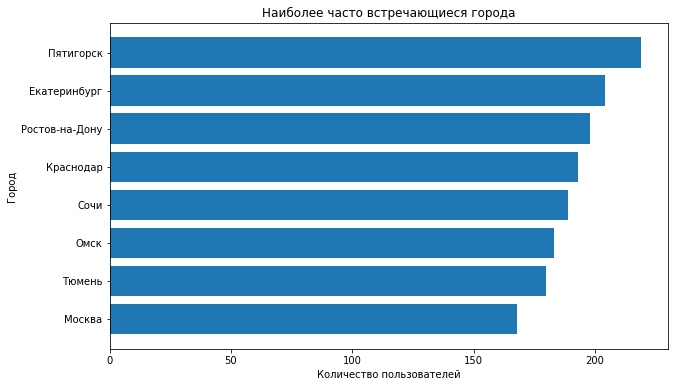

In [24]:
plt.figure(figsize=(10, 6))
plt.barh(city['city'], city['user_id'])
plt.xlabel('Количество пользователей')
plt.ylabel('Город')
plt.title('Наиболее часто встречающиеся города');

***Вывод:***

На графике видно, что наибольшеее количество пользователей сервиса арендуют самокаты в Пятигорске. На втором месте по количесву пользователей - Екатеринбург. Далее идут Ростов - на - Дону, Краснодар, Сочи, Омск и Тюмень. Несмотря на то, что Москва самый крупный из всех город, именно там меньше всего пользователей данного сервиса. Возможно, это связано с тем, что в москве большая конкуренция и у сервиса мало точек проката в городе. А возможно, сервис более ориентирован на другие регионы (южные и восточные).  

##### Соотношение пользователей с подпиской и без

In [25]:
subscription = users.pivot_table(index= 'subscription_type', values = 'user_id', aggfunc='count')
print(subscription)

                   user_id
subscription_type         
free                   835
ultra                  699


In [26]:
subscription['percentage'] = (subscription['user_id'] / subscription['user_id'].sum()) * 100
display(subscription.round(2))

,user_id,percentage
subscription_type,,
free,835,54.43
ultra,699,45.57


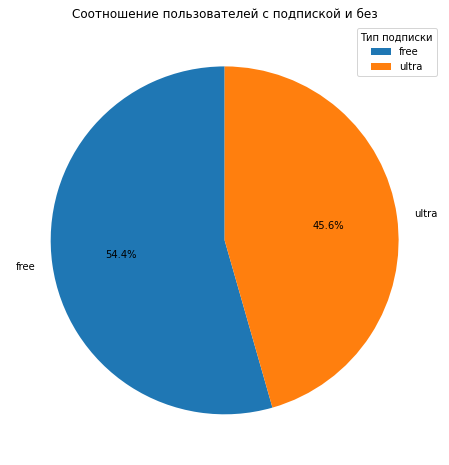

In [27]:
plt.figure(figsize=(8, 8))
plt.pie(
    subscription['user_id'], 
    labels=subscription.index, 
    autopct='%1.1f%%',
    startangle=90,
)
plt.title('Соотношение пользователей с подпиской и без')
plt.legend(subscription.index, title="Тип подписки", loc="best");

***Вывод:***

В таблице и на круговой диаграмме видно, что пользователей без подписки больше, чем пользователей с подпиской. Больше половины пользователей (54,4 %) не пользуются подпиской. И чуть меньше половины (46,4 %) используют платную подписку.

##### Возраст пользователей

In [28]:
age = users.pivot_table(index= 'age', values = 'user_id', aggfunc='count')
print(age)

     user_id
age         
12         4
13         8
14         9
15        13
16        19
17        26
18        46
19        47
20        71
21        93
22       119
23       129
24       132
25       145
26       131
27       119
28       112
29        68
30        68
31        48
32        41
33        39
34        19
35        15
36         6
37         2
38         3
39         1
43         1


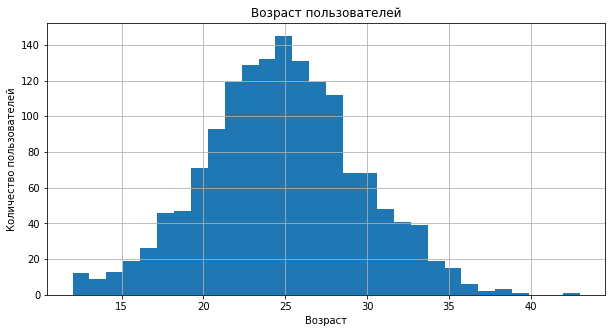

In [29]:
plt.figure(figsize=(10, 5))
plt.hist(age.index, weights=age['user_id'], bins=30)
plt.grid(True)
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Возраст пользователей');

In [30]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

***Вывод:***

Услугами данного сервиса проката самокатов пользуются люди в возрасте от 12 до 43 лет. Средний возраст пользователей составляет 25 лет, что совпадает с медианным возрастом, который также составляет 25 лет. Возраст, который среди пользователей встречается чаще всего - тоже составляет 25 лет. 75% пользователей не старше 28 лет. Распределение среднего возраста пользователей близок к нормальному распределению.

##### Расстояние, которое пользователь преодолел за одну поездку

In [31]:
rides['distance'].describe()

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

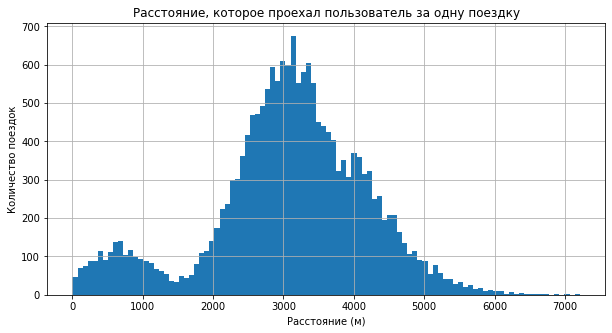

In [32]:
plt.figure(figsize=(10, 5))
rides['distance'].hist(bins=100)
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.title('Расстояние, которое проехал пользователь за одну поездку')
plt.grid(True);

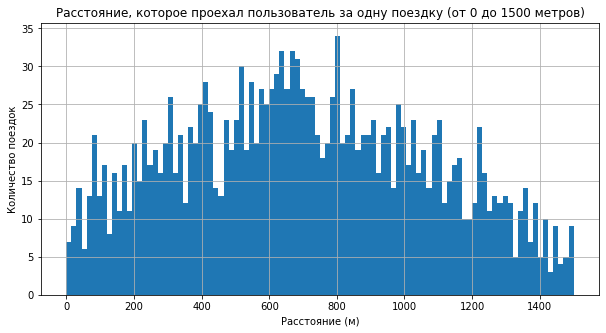

In [33]:
plt.figure(figsize=(10, 5))
rides['distance'].hist(bins=100, range = (0,1500))
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.title('Расстояние, которое проехал пользователь за одну поездку (от 0 до 1500 метров)')
plt.grid(True);

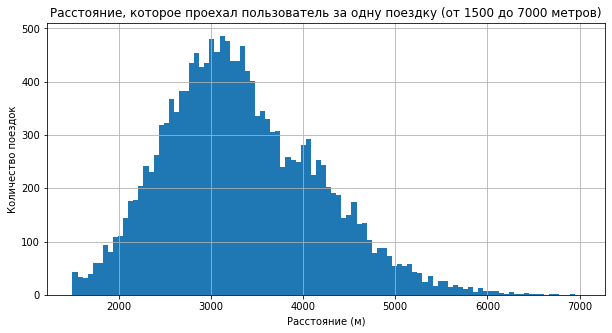

In [34]:
plt.figure(figsize=(10, 5))
rides['distance'].hist(bins=100, range = (1500,7000))
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.title('Расстояние, которое проехал пользователь за одну поездку (от 1500 до 7000 метров)')
plt.grid(True);

In [111]:
rides_short = rides.loc[rides['distance']<=1500]
rides_short.describe()

,user_id,distance,duration,month
count,1796.000000,1796.000000,1796.000000,1796.000000
mean,926.052895,703.889722,10.170278,6.540646
std,413.258205,368.353620,3.956316,3.507098
min,1.000000,0.860000,2.040000,1.000000
25%,674.500000,414.315000,6.920000,3.000000
50%,982.000000,687.535000,10.095000,7.000000
75%,1258.000000,985.435000,13.460000,10.000000
max,1534.000000,1499.570000,20.460000,12.000000


In [110]:
rides_long = rides.loc[rides['distance']>1500]
rides_long.describe()

,user_id,distance,duration,month
count,16272.000000,16272.000000,16272.000000,16272.000000
mean,833.688729,3331.889061,18.647691,6.480826
std,436.080907,826.722589,5.685551,3.429689
min,1.000000,1502.430000,0.500000,1.000000
25%,470.000000,2742.580000,14.590000,4.000000
50%,878.000000,3239.970000,18.390000,6.000000
75%,1207.000000,3874.557500,22.210000,9.000000
max,1534.000000,7211.010000,40.820000,12.000000


***Вывод:***

Минимальное расстояние одной поездки составляет менее 1 метра, максимальное - 7211 метров. В среднем пользователи за одну поездку проезжали 3070 метров. Медиана находится чуть дальше, и составляет 3 133 метра.  
На гистограмме можно наблюдать два пика: крупный в районе 3100 метров, и второй, меньший пик в районе 700 метров. Наличие двух пиков может указывать на то, что существует два сценария использования приложения: группа пользователей проезжает до 1500 метров (в среднем 700 метров), и вторая группа, которая совершает более длительные поездки - от 1500 до 7211 метров(в среднем 3331 метр). С этими двумя группами пользователей можно работать по-разному, используя для каждой свои маркетинговые приёмы.

##### Продолжительность поездок

In [35]:
rides['duration'].describe()

count    18068.000000
mean        17.805017
std          6.091071
min          0.500000
25%         13.600000
50%         17.680000
75%         21.722500
max         40.820000
Name: duration, dtype: float64

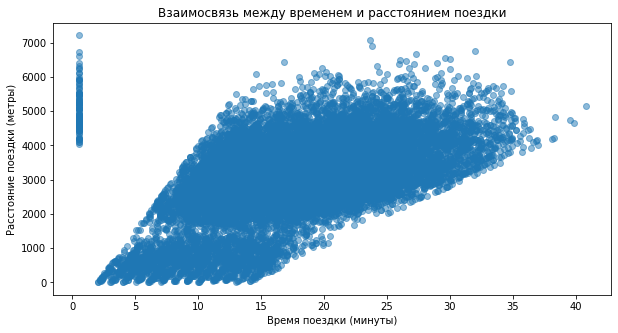

In [36]:
plt.figure(figsize=(10, 5))
plt.scatter(rides['duration'], rides['distance'], alpha=0.5)
plt.xlabel('Время поездки (минуты)')
plt.ylabel('Расстояние поездки (метры)')
plt.title('Взаимосвязь между временем и расстоянием поездки')
plt.show()

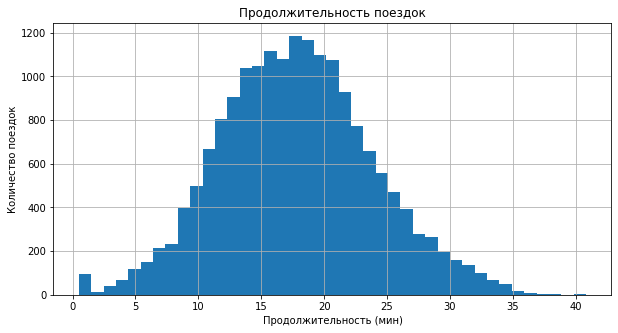

In [37]:
plt.figure(figsize=(10, 5))
rides['duration'].hist(bins=41)
plt.xlabel('Продолжительность (мин)')
plt.ylabel('Количество поездок')
plt.title('Продолжительность поездок')
plt.grid(True);

Большой вопрос вызывает большое количество поездок короче 1 минуты. Их стоит рассмотреть более подробно. 

In [38]:
short_rides = rides[rides['duration'] < 1]
print(len(short_rides))

95


In [39]:
short_rides['distance'].describe()

count      95.000000
mean     5113.176737
std       658.254223
min      4030.310000
25%      4611.510000
50%      5052.770000
75%      5488.460000
max      7211.010000
Name: distance, dtype: float64

Изучив данные по по поедкам короче 1 минуты, мы видим, что средняя дистанция, которую проехали пользователи за это время составляет 5113 метров (около 5 километров), а минимальная - 4030 метров (4 километра), что никак не может соответствовать действительности.

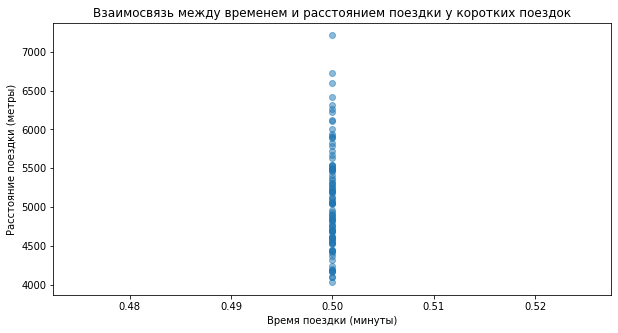

In [40]:
plt.figure(figsize=(10, 5))
plt.scatter(short_rides['duration'], short_rides['distance'], alpha=0.5)
plt.xlabel('Время поездки (минуты)')
plt.ylabel('Расстояние поездки (метры)')
plt.title('Взаимосвязь между временем и расстоянием поездки у коротких поездок')
plt.show()

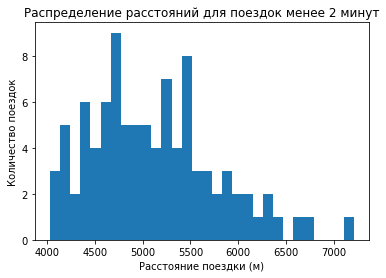

In [41]:
short_rides = rides[rides['duration'] < 2] 
plt.hist(short_rides['distance'], bins=30)
plt.xlabel('Расстояние поездки (м)')
plt.ylabel('Количество поездок')
plt.title('Распределение расстояний для поездок менее 2 минут')
plt.show()

На графиках видно, что что все короткие поездки были совершены за время 0,5 минут, а максимальное расстояние, которое проехали пользователи, составило 7211 метров. Проехать 7 километров за пол секунды невозможно, да и само время поездки в пол секунды тоже вызывает вопросы. Скорее всего, речь идёт об техническом сбое программы на самокатах (неправильная фиксация времени) или же об ошибке при выгрузке данных. На этот вопрос компании стоит обратить дополнительное внимание.

In [42]:
rides_n = rides[rides['duration'] > 1]

In [43]:
rides_n['distance'].describe()

count    17973.000000
mean      3059.863849
std       1108.814623
min          0.860000
25%       2538.840000
50%       3129.030000
75%       3762.640000
max       7066.000000
Name: distance, dtype: float64

In [44]:
rides_n['duration'].describe()

count    17973.000000
mean        17.896486
std          5.975444
min          2.040000
25%         13.670000
50%         17.710000
75%         21.750000
max         40.820000
Name: duration, dtype: float64

Без учёта аномально коротких поездок среднее время одной поездки составило 17,89 минут, а среднее расстояние - 3059 метров (было 3070 метров). 

***Вывод:***

Продолжительность поездок варьируется в пределах от 1 минуты до 41 минуты. Среднее и медианное значения приктически совпадают и составляют около 18 минут. Две трети пользователей (75%) использовали самокат в пределах 22 минут. Стоит обратить внимание на выделяющиеся значения в районе 1-2 минут - таких коротких поездок оказалось 95. С учётом более детального анализа коротких поездок (до 1 минуты) было выявлено, что все 95 поездок были совершены за время 0,5 минут, а максимальное зафиксированное расстояние составило 7211 метров. Проехать 7 километров за пол секунды невозможно, да и само время поездки в пол секунды тоже вызывает вопросы. Скорее всего, речь идёт об техническом сбое программы на самокатах (неправильная фиксация времени) или же об ошибке при выгрузке данных. На этот вопрос компании стоит обратить дополнительное внимание.

# ***Вывод:***

Больше всего сервис популярен в Пятигорске, Екатеринбурге и Ростове-на-Дону, а менее всего - в Омске, Тюмени и Москве. В основном, на первых позициях списка расположены южные города, где сезон проката самокатов дольше. Исключение совставляет город Екатеринбург, находящийся на втором месте. Возможно, это связано с тем, что Екатеринбург - довольно крупный город (второй из представленных после Москвы по численности населения), и самокат там является достаточно популярным видом транспорта благодаря своей доступности, удобству и скорости передвижения.

Больше половины пользователей (54,4%) пользуюся сервисом без платной подписки. Платную подписку используют 45,6% пользователей.

Услугами сервиса пользуются люди от 12 до 43 лет, а средний возраст пользователя составляет 25 лет. Этот же возраст является и модой, и медианой. В целом можно сказать, что сервис проката самокатов более популярен у молодых людей - две трети пользователей не старше 28 лет.

Минимальное расстояние одной поездки составляет менее 1 метра, максимальное - чуть больше 7 километров (7211 метров). В среднем пользователи за одну поездку проезжали около 3 километров (3070 метров). Наличие двух пиков даёт повод предположить, что существует два сценария использования приложения: группа пользователей проезжает до 1500 метров (в среднем 700 метров), и вторая группа, которая совершает более длительные поездки - от 1500 до 7211 метров(в среднем 3331 метр). С этими двумя группами пользователей можно работать по-разному, используя для каждой свои маркетинговые приёмы.

При построении гистограммы можно наблюдать два пика: крупный в районе 3100 метров, и второй, меньший пик в районе 700 метров. 

Продолжительность поездок находится в пределах от 1 минуты до 41 минуты. Среднее и медианное значения приктически совпадают и составляют около 18 минут. Две трети пользователей (75%) использовали самокат в пределах 22 минут, что вполне соотносится с тем, что две трети поездок находились в пределах 3776 метров. Стоит обратить внимание на выделяющиеся значения в районе 1-2 минут - таких коротких поездок оказалось 95. С учётом более детального анализа было выявлено, что все короткие поездки были совершены за  однаковое время 0,5 минут, а максимальное зафиксированное расстояние составило 7211 метров. Проехать 7 километров за пол секунды невозможно, да и само время поездки в пол секунды тоже вызывает вопросы. Скорее всего, речь идёт об техническом сбое программы на самокатах (неправильная фиксация времени) или же об ошибке при выгрузке данных. На этот вопрос компании стоит обратить дополнительное внимание.

#### Шаг 4. Объединение данных

##### Объединение данных в один датафрейм

In [45]:
total = users.merge(rides, on = 'user_id')
total = total.merge(subscriptions, on = 'subscription_type')

In [46]:
display(total)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,25.60,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,15.82,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.23,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,18.51,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26.27,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.10,19.82,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.42,21.41,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.19,18.44,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.31,16.67,2021-11-27,11,8,50,0


In [47]:
# проверим новый датафрейм на наличие дубликатов 
print ('Количество явных дубликатов в новом датафрейме:', total.duplicated().sum())

Количество явных дубликатов в новом датафрейме: 0


In [48]:
print('Количество уникальных пользователей в первоначальном датафрейме:', len(users['user_id'].unique()))
print('Количество уникальных пользователей в новом датайрейме:', len(total['user_id'].unique()))

Количество уникальных пользователей в первоначальном датафрейме: 1534
Количество уникальных пользователей в новом датайрейме: 1534


In [49]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


***Вывод:***

На данном шаге мы соединили три отдельных датафрейма в один общий. В новом датафрейме - 18 068 строк и 12 столбцов. Дубликатов и пропусков обнаружено не было. Количество уникальных пользователей сохранилось.

##### Создание новых датафреймов

###### Создание датафрейма с данными пользователей без подписки 

In [50]:
users_free = total[total['subscription_type']=='free']
display(users_free)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.69,14.94,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.93,16.23,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.43,20.02,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.91,9.78,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.38,17.43,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.10,19.82,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.42,21.41,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.19,18.44,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.31,16.67,2021-11-27,11,8,50,0


###### Создание датафрейма с данными пользователей с платной подпиской

In [51]:
users_ultra = total[total['subscription_type']=='ultra']
display(users_ultra)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,25.60,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,15.82,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,6.23,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,18.51,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,26.27,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.05,24.67,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.70,15.89,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.16,14.39,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.85,15.84,2021-10-17,10,6,0,199


In [52]:
print('Суммарная длина двух новых датафреймов:',len(users_free) + len(users_ultra))

Суммарная длина двух новых датафреймов: 18068


Суммарное количество строк двух новых датафреймов составляет 18 068 строк, что равно количеству строк изначального датафрейма. Датафреймы были розделены корректно.

##### Визуализация информации

###### Пользователи без подписки

In [53]:
users_free['distance'].describe()

count    11568.000000
mean      3045.495284
std       1246.173810
min          0.860000
25%       2366.560000
50%       3114.650000
75%       3905.695000
max       7211.010000
Name: distance, dtype: float64

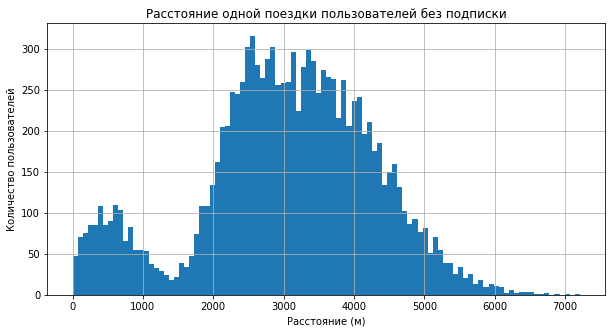

In [54]:
plt.figure(figsize=(10, 5))
users_free['distance'].hist(bins=100)
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество пользователей')
plt.title('Расстояние одной поездки пользователей без подписки')
plt.grid(True);

In [55]:
users_free['duration'].describe()

count    11568.000000
mean        17.390900
std          6.326821
min          0.500000
25%         12.960000
50%         17.330000
75%         21.592500
max         34.950000
Name: duration, dtype: float64

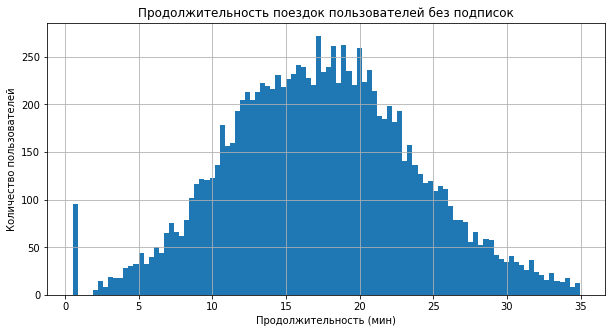

In [56]:
plt.figure(figsize=(10, 5))
users_free['duration'].hist(bins=100)
plt.xlabel('Продолжительность (мин)')
plt.ylabel('Количество пользователей')
plt.title('Продолжительность поездок пользователей без подписок')
plt.grid(True);

###### Пользователи с подпиской

In [57]:
users_ultra['distance'].describe()

count    6500.000000
mean     3115.445431
std       836.895369
min       244.210000
25%      2785.447500
50%      3148.640000
75%      3560.577500
max      5699.770000
Name: distance, dtype: float64

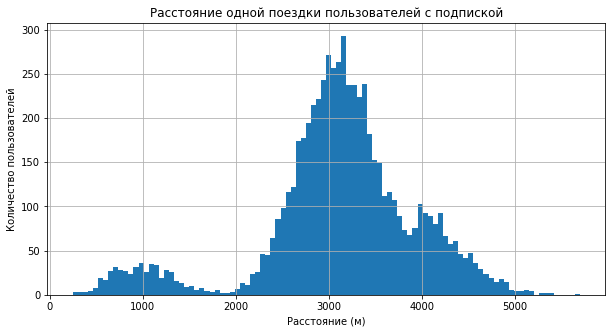

In [58]:
plt.figure(figsize=(10, 5))
users_ultra['distance'].hist(bins=100)
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество пользователей')
plt.title('Расстояние одной поездки пользователей с подпиской')
plt.grid(True);

In [59]:
users_ultra['duration'].describe()

count    6500.000000
mean       18.542017
std         5.572065
min         3.760000
25%        14.527500
50%        18.180000
75%        21.880000
max        40.820000
Name: duration, dtype: float64

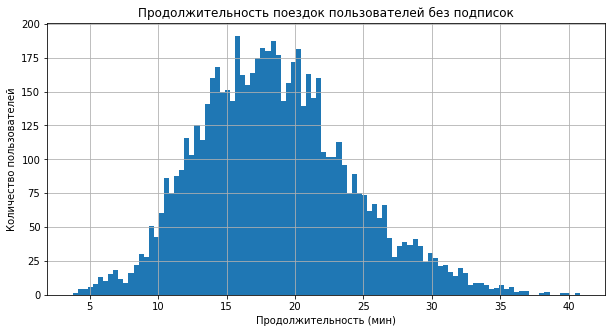

In [60]:
plt.figure(figsize=(10, 5))
users_ultra['duration'].hist(bins=100)
plt.xlabel('Продолжительность (мин)')
plt.ylabel('Количество пользователей')
plt.title('Продолжительность поездок пользователей без подписок')
plt.grid(True);

###### Общие графики

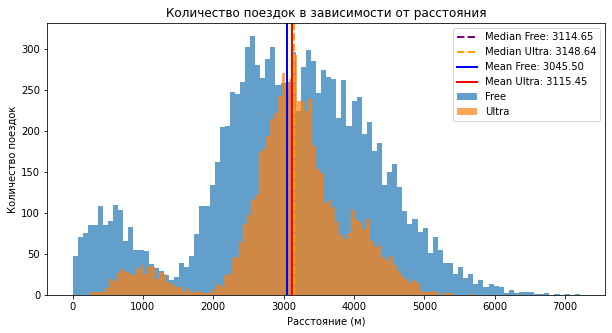

In [61]:
median_free = users_free['distance'].median()
median_ultra = users_ultra['distance'].median()
mean_free = users_free['distance'].mean()
mean_ultra = users_ultra['distance'].mean()


plt.figure(figsize=(10, 5))
plt.hist(users_free['distance'], bins=100, alpha=0.7, label='Free') 
plt.hist(users_ultra['distance'], bins=100, alpha=0.7, label='Ultra')

plt.axvline(median_free, color='purple', linestyle='dashed', linewidth=2, label=f'Median Free: {median_free:.2f}')
plt.axvline(median_ultra, color='orange', linestyle='dashed', linewidth=2, label=f'Median Ultra: {median_ultra:.2f}')

plt.axvline(mean_free, color='blue', linestyle='solid', linewidth=2, label=f'Mean Free: {mean_free:.2f}')
plt.axvline(mean_ultra, color='red', linestyle='solid', linewidth=2, label=f'Mean Ultra: {mean_ultra:.2f}')

plt.legend()

plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.title('Количество поездок в зависимости от расстояния');

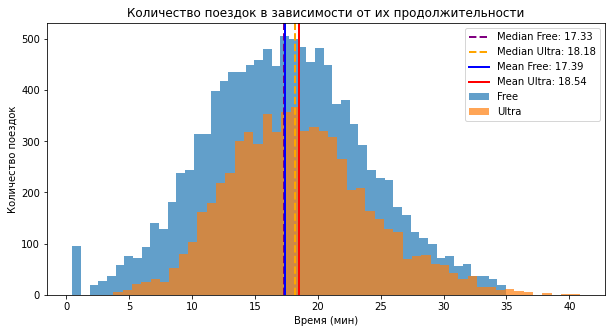

In [62]:
median_free_duration = users_free['duration'].median()
median_ultra_duration = users_ultra['duration'].median()
mean_free_duration = users_free['duration'].mean()
mean_ultra_duration = users_ultra['duration'].mean()


plt.figure(figsize=(10, 5))
plt.hist(users_free['duration'], bins=50, alpha=0.7, label='Free') 
plt.hist(users_ultra['duration'], bins=50, alpha=0.7, label='Ultra')

plt.axvline(median_free_duration, color='purple', linestyle='dashed', linewidth=2, label=f'Median Free: {median_free_duration:.2f}')
plt.axvline(median_ultra_duration, color='orange', linestyle='dashed', linewidth=2, label=f'Median Ultra: {median_ultra_duration:.2f}')

plt.axvline(mean_free_duration, color='blue', linestyle='solid', linewidth=2, label=f'Mean Free: {mean_free_duration:.2f}')
plt.axvline(mean_ultra_duration, color='red', linestyle='solid', linewidth=2, label=f'Mean Ultra: {mean_ultra_duration:.2f}')

plt.legend()

plt.xlabel('Время (мин)')
plt.ylabel('Количество поездок')
plt.title('Количество поездок в зависимости от их продолжительности');

# ***Вывод:***

Поездок без подписки было совершено почти в два раза больше, чем с подписками (11568 и 6500 соответственно).

Среднее расстояние, которое проезжали пользователи без подписки меньше,чем у пользователей с подпиской (3045 и 3115 метров), однако пользователи без подписки совершали более длительные поездки (максимальное расстояние - 7211 метров), у пользователей с подпиской максимальное расстояние составляет 5699 метров. На графике можно видеть и то, что пользователи без подписок совершали много очень коротких поездок (до 1 метра), тогда как минимальное значение с подпиской - 244 метра. Первый (маленький) пик у пользователей без подписки находится в районе 600 метров, когда у пользователей с подпиской - в районе 1000 метров.

В среднем пользователи с платной подпиской проводили в поездке больше времени, чем пользователи без подписки (18,54 и 17,39 минут соответственно). Так же на графике видно, что пользователи без подписки совершили много коротких поездок. Эта проблема характерна именно для пользователей без платной подписки, и компании следует провести более подробный анализ этой категории пользователей, и выяснить, является ли причиной технический сбой, или проблема заключается в чём-то ином. Пользователи с платной подпиской наоборот, совершали более длительные поездки (самая долгая длилась около 40 минут), а самая длинная у пользователей без подписки - 35 минут.

В целом можно сказать, что пользователи с платной подпиской совершали более длинные и долгие поездки, чем пользователи без подписки.

#### Шаг 5. Подсчёт выручки

##### Создание нового датафрейма с агрегированными данными о поездках

In [63]:
total['duration'] = np.ceil(total['duration'])

In [64]:
revenue = total.pivot_table(
    index=('user_id', 'month'),
    values=('distance', 'duration', 'minute_price','start_ride_price', 'subscription_fee'),
    aggfunc=({'distance': {'count','sum'}, 'duration': 'sum', 'minute_price': 'mean', 
              'start_ride_price': 'mean', 'subscription_fee': 'mean'})
)

revenue.columns = ['count', 'distance','duration', 'minute_price', 'start_ride_price', 'subscription_fee']
display(revenue)


count  distance  duration  minute_price  start_ride_price  \
user_id month                                                              
1       1          2   7027.51      42.0             6                 0   
        4          1    754.16       7.0             6                 0   
        8          2   6723.47      46.0             6                 0   
        10         2   5809.91      32.0             6                 0   
        11         3   7003.50      56.0             6                 0   
...              ...       ...       ...           ...               ...   
1534    6          2   3409.47      26.0             8                50   
        8          2   7622.45      48.0             8                50   
        9          1   4928.17      23.0             8                50   
        11         4  13350.02      78.0             8                50   
        12         1   2371.71      16.0             8                50   

               subscription_fee  
user_id month                    
1       1                   199  
        4                   199  
        8                   199  
        10                  199  
        11                  199  
...                         ...  
1534    6                     0  
        8                     0  
        9                     0  
        11                    0  
        12                    0  

[11331 rows x 6 columns]

In [65]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11331 entries, (1, 1) to (1534, 12)
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   count             11331 non-null  int64  
 1   distance          11331 non-null  float64
 2   duration          11331 non-null  float64
 3   minute_price      11331 non-null  int64  
 4   start_ride_price  11331 non-null  int64  
 5   subscription_fee  11331 non-null  int64  
dtypes: float64(2), int64(4)
memory usage: 576.5 KB


In [66]:
revenue.duplicated().sum()

1

In [67]:
duplicates = revenue[revenue.duplicated(keep=False)]

print("Дубликаты:")
print(duplicates)

Дубликаты:
               count  distance  duration  minute_price  start_ride_price  \
user_id month                                                              
1015    12         1   2595.29      12.0             8                50   
1219    12         1   2595.29      12.0             8                50   

               subscription_fee  
user_id month                    
1015    12                    0  
1219    12                    0  


Был создан новый датайрейм, с данными, сгруппированными по пользователю и месяцам. В новом датайрейме получилось 11331 строк и 6 столбцов. Метод duplicated() показал, что в датафрейме присутствуетдубликат, однако, при более подродном рассмотрении оказалось, что это не  так: пользователи имеют разный 'user_id', а идентичность показателей связана с округлением продолжительности поездкт до следующего целого числа.

In [68]:
revenue['revenue_per_month'] = (
    revenue['start_ride_price'] * revenue['count'] + 
    revenue['minute_price'] * revenue['duration'] + revenue['subscription_fee']
)

In [69]:
display(revenue)

count  distance  duration  minute_price  start_ride_price  \
user_id month                                                              
1       1          2   7027.51      42.0             6                 0   
        4          1    754.16       7.0             6                 0   
        8          2   6723.47      46.0             6                 0   
        10         2   5809.91      32.0             6                 0   
        11         3   7003.50      56.0             6                 0   
...              ...       ...       ...           ...               ...   
1534    6          2   3409.47      26.0             8                50   
        8          2   7622.45      48.0             8                50   
        9          1   4928.17      23.0             8                50   
        11         4  13350.02      78.0             8                50   
        12         1   2371.71      16.0             8                50   

               subscription_fee  revenue_per_month  
user_id month                                       
1       1                   199              451.0  
        4                   199              241.0  
        8                   199              475.0  
        10                  199              391.0  
        11                  199              535.0  
...                         ...                ...  
1534    6                     0              308.0  
        8                     0              484.0  
        9                     0              234.0  
        11                    0              824.0  
        12                    0              178.0  

[11331 rows x 7 columns]

In [70]:
print('Общая выручка за год составила:', revenue['revenue_per_month'].sum())

Общая выручка за год составила: 3877893.0


В датафрейм был добавлен новый столбец 'revenue_per_month' с расчётом помесячной выручки, которую принёс каждый пользователь. Общая выручка составили 3 877 893 рубля.

# ***Вывод:***

Был созднан новый датафрейм revenue, который содержит агрегированные данные о поездках (суммарное расстояние, количество поездок  и время для каждого пользователя). В датафрейме получилось 11331 строка и 6 столбцов. Далее был добавлен ещё один столбец с помесячной выручкой от каждого пользователя. Суммарная выручка составила 3 877 893 рубля.

#### Шаг 6. Проверка гипотез

В этом шаге нужно будет проверить 3 гипотезы:
1. пользователи с подпиской тратят больше времени на поездки, чем пользователи без;
2. среднее расстояние, которое проезжают за одну поездку пользователи с подпиской не превышает 3130 метров;
3. помесячная выручка от пользователей с подпиской по месяцам будет выше, чем выручка от пользователей без подписки

##### Проверка гипотезы, что пользователи с подпиской тратят больше времени на поездки.

Необходимо проверить следующие гипотезы:  
H0: Пользователи с подпиской и без подписки тратят одинаковое время на поездки;  
H1: Пользователи с подпиской тратят больше времени на поездки.

Нужно сравнить две независимые выборки, для этого будем использовать метод ttest_ind(). В качестве альтернативной гипотезы мы проверяем, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки. Это односторонний (правосторонний) тест.    
Уровень статистической значимости примем равным 5%.

In [80]:
alpha = 0.05

results = st.ttest_ind(users_ultra['duration'], users_free['duration'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
    

p-значение: 1.274138957151199e-34
Отвергаем нулевую гипотезу


In [81]:
print('Среднее время поезки пользователей с подпиской:', users_ultra['duration'].mean())
print('Среднее время поездки пользователей без подписки:', users_free['duration'].mean()) 

Среднее время поезки пользователей с подпиской: 18.542016923076922
Среднее время поездки пользователей без подписки: 17.390899896265562


По результатам теста мы можем отвергнуть нулевую гипотезу, и можем предположить, что пользователи с подпиской действительно тратят больше времени на поездки чем те, у кого подписки нет (при данном уровне значимости в 5%).

##### Проверка гипотезы, что среднее расстояние за одну поездку с подпиской не превышает 3130 метров

H0: Среднее расстояние за одну поезку с подпиской равно 3130 метров;  
H1: Среднее расстояние за одну поездку с подпиской больше 3130 метров.  

Здесь нужно сравнить выборку с заданным числом. Для этого будем использоат метод ttest_1samp(). Будем проверять альтернативную теорию о том, что пользователи проезжают больше заданного числа, это односторонний (правосторонний) тест.  
Уровень статистической значимости примен равным 5%.

In [82]:
alpha = 0.05

opt_distance = 3130
results = st.ttest_1samp(users_ultra['distance'], opt_distance, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195362605842414
Не получилось отвергнуть нулевую гипотезу


In [83]:
print('Среднее расстояние, которое проехали пользователи с платной подпиской:', round(users_ultra['distance'].mean(),2))

Среднее расстояние, которое проехали пользователи с платной подпиской: 3115.45


С помощью теста не удалось отвергнуть нулевую гипотезу, а значит, можно предположить, что среднее расстояние за одну поезку у пользователей с подпиской действительно не превышает оптимальное расстояние в 3130 метров (при заданном уровне значимости в 5%).

##### Проверка гипотезы, что помесячная выручка по месяцам от пользователей с подпиской будет выше, чем выручка от пользователей без подписки .

H0: Помесячная выручка по месяцам от пользователей с подпиской равна выручке от пользователей без подписки;  
H1: Помесячная выручка от пользователей с подпиской больше, чем от пользователей без подписки.

В этом задании снова нужно сравнить между собой две независимые выборки. Для этого будем использовать метод ttest_ind(). В качестве альтернативной гипотезы проверяем, что пользователи с подпиской приносят больше прибыли, чем пользователи без подписки. Это односторонний (правосторонний) тест.  
Уровень статистической значимости примем равным 5%.

In [74]:
alpha = 0.05

results = st.ttest_ind(
    revenue.loc[revenue['subscription_fee']>0, 'revenue_per_month'], 
    revenue.loc[revenue['subscription_fee']==0, 'revenue_per_month'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.8164914860049708e-31
Отвергаем нулевую гипотезу


По результатам теста мы можем отвергнуть нулевую гипотезу, и можем предположить, что помесячная выручка от пользователей с подпиской действительно выше, чем от пользователей без подписки (при данном уровне значимости в 5%).

In [106]:
revenue_month = revenue.pivot_table(index='month', values='revenue_per_month', columns='subscription_fee')
revenue_month.columns=['free','ultra']
display(revenue_month)

,free,ultra
month,,
1,323.016667,369.446154
2,313.406427,351.830508
3,336.687050,360.045455
4,335.591320,367.112299
5,328.094241,368.377778
6,326.098472,361.346734
7,329.163701,367.800000
8,331.107965,360.703125
9,335.646447,364.295775


В таблице можно увидеть, что среднемесячная выручка от пользователей с платной подпиской действительно выше, чем от пользователей без подписки.

##### Ответ на вопрос

Для проверки этой гипотезы нам понадобился бы тест для сравнения двух зависимых выборок. Для этих выборок переменная измеряется дважды для одних и тех же объектов. В даннном случае это пара измерений для каждого пользователя - до и после проведения изменения. В Python для проведения этого теста существует специальный метод scipy.stats.ttest_rel(), которому в качестве аргументов передаются обе выборки (до и после изменений). 

# ***Вывод:***

По проверенным гипотезам можно сделать следующие выводы:
1. При проверки первой гипотезы о том, что пользователи с платной подпиской в среднем совершают более длительные по времени поездки, после проведения теста мы можем отвергнуть нулевую гипотезу, и предположить, что пользователи с подпиской действительно тратят больше времени на поездки чем те, у кого подписки нет. Это нам подтверждает и метод describe(), применённый к анализирумым столбцам: среднее время поздки пользователей с платной подпиской составляет 18,54 минуты, а у пользователей без подписки - 17,з9 минут.  


2. При проверке гипотезы о том, что пользователи с платной подпиской в среднем проезжают меньше заданного оптимального расстояния, по результатам теста нам не удалось отвергнуть нулевую гипотезу, и можно предположить, что среднее расстояние за одну поезку у пользователей с подпиской действительно не превышает оптимальное расстояние в 3130 метров. Подтверждение можно получить, и использовав метод describe(): среднее расстояние, которое проезжали пользователи с платной подпиской составляет 3115,44 метра, что меньше данного в услолвии оптимального значения (3130 метров).


3. При проверке третьей гипотезы о том, что помесячная выручка от пользователей с платной подпиской больше, чем от пользователей без подписки, результаты теста показали, что мы можем отвергнуть нулевую гипотезу, и предположить, что помесячная выручка от пользователей с подпиской действительно выше, чем от пользователей без подписки. 

#### Шаг 7. Распределения

##### Определение минимального числа промокодов

Отделу маркетинга была поставлена задача провестии акцию с раздачей промокодов на один бесплатный месяц подписки, с целью, чтобы хотя бы 100 клиентов по истечению пробного м есяца подписку продлили.
Необходимо найти минимальное количество промокодов, которое необходимо разослать, чтобы вероятность не выполнить план (как минимум 100 клиентов должны продлить подписку) была около 5%. 

In [75]:
n= 1000 
p = 0.1  # вероятность продления подписки
k = 100  # требуемое число продлений
target_p = 0.95  # требуемая вероятность успеха (5% - неудача из условия)

# 1- st.binom.cdf(k - 1, n, p) дает вероятность того, что число успехов будет 100 или больше

while 1- st.binom.cdf(k - 1, n, p) < target_p:
    n += 1

print(f'Необходимое минимальное количество промокодов: {n}')



Необходимое минимальное количество промокодов: 1161


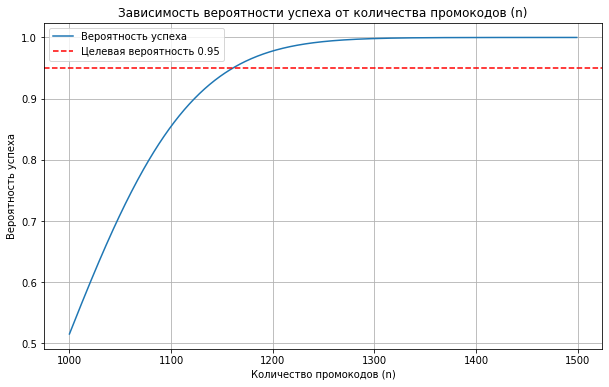

In [76]:
# график
n_values = np.arange(1000, 1500)  # диапазон значений n


probabilities = []

for n in n_values:
    prob = 1 - st.binom.cdf(k - 1, n, p)
    probabilities.append(prob)
                                  
plt.figure(figsize=(10, 6))
plt.plot(n_values, probabilities, label='Вероятность успеха')
plt.axhline(y=target_p,color='red', linestyle='--', label=f'Целевая вероятность {target_p}')

# Настройки графика
plt.title('Зависимость вероятности успеха от количества промокодов (n)')
plt.xlabel('Количество промокодов (n)')
plt.ylabel('Вероятность успеха')
plt.legend()
plt.grid(True)
plt.show()

***Вывод:***

Для выполнения поставленной задачи (чтобы как минимум 100 клиентов продлили подписку на следующий месяц, а вероятность неудачи выполнения плана составляла 5%) отделу маркетинга необходимо разослать не меньше 1161 промокодов. Распределение вероятностей успеха можно увидет на графике.

##### Определение вероятности открытия  уведомлений

Отдел маркетинга рассылает push-уведомления, которые пользователи могут открыть или не открыть. Известно, что уведомления открывают около 40% клиентов. Отдел планирунт разослать 1 миллион уведомлений.  
Нужно оценить вероятность, что уведомление откроют не более 399,5 тысяч пользователей.

In [77]:
n = 1000000
p = 0.4

# зададим мат.ожидание и ст.отклонение нормального распределения равными
# мат.ожиданию и ст.отклонению биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))

# задаём нормальное распределение
distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399,5 тысяч
result = distr.cdf(399500)
print('Вероятность того, что уведомление откроют не более 399,5 тысяч пользователей равна', round(result*100,2),'%')

Вероятность того, что уведомление откроют не более 399,5 тысяч пользователей равна 15.37 %


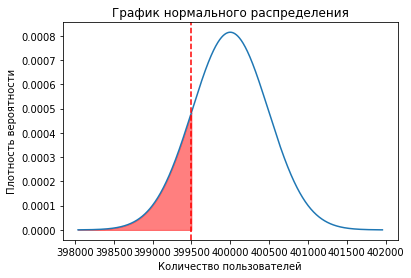

In [78]:
mu = n * p
sigma = np.sqrt(n * p * (1 - p))

# Задаем нормальное распределение
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
distr = st.norm(mu, sigma)
pdf = distr.pdf(x)

# Строим график нормального распределения
plt.plot(x, pdf)

# Закрашиваем область до 399500 (слева от 399500)
x_fill = np.linspace(mu - 4*sigma, 399500, 1000)
plt.fill_between(x_fill, distr.pdf(x_fill), color='red', alpha=0.5)

# Добавляем метки на оси и легенду
plt.axvline(399500, color='red', linestyle='--')
plt.title ('График нормального распределения')
plt.xlabel('Количество пользователей')
plt.ylabel('Плотность вероятности');

***Вывод:***

Если отдел маркетинга разошлёт 1 000 000 уведомлений, с условием, что открывают их около 40% пользователей, то вероятность того, что уведомление откроют не более 399,5 тысяч пользователей равна 15.37 %

# ***Общий вывод по проекту:***

Для проекта был проведён анализ данных сервиса по аренде самокатов и проверены требуемые гипотезы.

1. В начале была изучена общая информация о датафреймах, произведена проверка на отсутствующие значения и дубликаты, проверены типы данных.  
* В первом датафрейме *users* представлены данные о пользователях: их идентификационном номере, имени, возрасте, городе и типе подписки. В датафрейме 1565 строк и 5 столбцов, ни в одном столбце нет пропущенных значений. В датефрейме был найден 31 явный дубликат.

* Во втром датафрейме *rides* представлена информация о поездках: идентификационный номер пользователя, расстояние, длительность поездок и их даты. В датефрейме 18068 строк, 4 столбца. Ни в одном из столбцов нет пропущенных значений. Явных дубликатов нет.

* В третьем датафрейме *subscriptions* содержится информация о подписке: есть ли она у пользователя или нет, сколько стоит подписка, сколько стоит минута поездки с подпиской и без, и сколько стоит начало поезки с подпиской и без. В датафрейме 2 строки и 4 столбца. Пропусков и явных дубликатов в датафрейме нет.

2. Была проведена предобработка - работа с ошибками, пропусками и дубликатами (явными и неявными) в данных.

* В датафрейме users были удалены явные дубликаты в столбце 'user_id' (31 дубликат). В результате, в датафрейме осталось 1534 строки;
* В датафрейме rides были проведены следующие изменения:
 - столбец 'date' приведён к правильному формату;
 - добавлен новый столбец 'month', содержащий в себе порядковый номер месяца совершения поездки;
 - значения в столбце 'distance' были округлены до двух знаков после запятой;
 - значения в столбце 'duration' были округлены до двух знаков после запятой;
* В датафрейме subscriptions предобработка данных не потребовалась.

3. Был произведён исследовальский анализ данных, в результате которого удалось устаовить, что:
* Наибольшей популярностью сервис пользуется в Пятигорске, Екатеринбурге и Ростове-на-Дону, а менее всего он популярен в Омске, Тюмени и Москве. В основном, на первых позициях списка расположены южные города, где сезон проката самокатов дольше. Исключение совставляет город Екатеринбург, находящийся на втором месте. Это можно связать с тем, что Екатеринбург - довольно крупный город (второй из представленных после Москвы по численности населения), и самокат там является достаточно популярным видом транспорта благодаря своей доступности, удобству и скорости передвижения.

* Больше половины пользователей (54,4%) пользуюся сервисом без платной подписки. Платную подписку используют 45,6% пользователей.

* Услугами сервиса пользуются люди от 12 до 43 лет, а средний возраст пользователя составляет 25 лет. Этот же возраст является и модой, и медианой. В целом можно сказать, что сервис проката самокатов более популярен у молодых людей - две трети пользователей не старше 28 лет.

* Минимальное расстояние одной поездки составляет менее 1 метра, максимальное - чуть больше 7 километров (7211 метров). В среднем пользователи за одну поездку проезжали около 3 километров (3070 метров). На графике присутствуют два пика, что может означать, что существуют две группы пользователей которые используют приложение по-разному. Эти две группы стоит рассматривать отдельно и применять к ним разные маркетинговые техники. С аномально маленькие расстояния должны стать вопросом для более серьёзного исследования. 

* Продолжительность поездок находится в пределах от 1 минуты до 41 минуты. Среднее и медианное значения приктически совпадают и составляют около 18 минут. Две трети пользователей (75%) использовали самокат в пределах 22 минут, что вполне соотносится с тем, что две трети поездок находились в пределах 3776 метров. Стоит обратить внимание на выделяющиеся значения в районе 1-2 минут - таких коротких поездок оказалось 95.Все короткие поездки были совершены за время 0,5 минут, а максимальное зафиксированное расстояние составило 7211 метров. Проехать 7 километров за пол секунды невозможно, да и само время поездки в пол секунды тоже вызывает вопросы. Скорее всего, речь идёт об техническом сбое программы на самокатах (неправильная фиксация времени) или же об ошибке при выгрузке данных. На этот вопрос компании стоит обратить дополнительное внимание. Эти значения, как и маленькие расстояния, требуют более подробного исследования. Стоит также обратить внимание, что данная проблема характерна для пользователей без подписки (все аномально короткие поездки были совершены ими). Компании стоит отдельно рассмотреть эту группу пользователй и выяснить причины таких коротких поездок (проблема в програмном обеспечении или в чём-то другом)  

В целом, можно сказать то, что пользователи с платной подпиской совершили практически в 2 раза меньше поездок, чем пользователи без подписки, однако среднее время и среднее расстояние одной поездки у них больше.

4. Далее имеющиеся данные был обединены в один общий датафрейм и на его основе созданы два новых датафрейма: С информацией о пользователях с платной подпиской и пользователях без подписки.  
На основании новых датафреймов были построены графики для сравнения времени и расстояния поездок у пользователей с платной подпиской и без подписки.  

На основании проделанной работы были сделаны следующие выводы:
* Поездок без подписки было совершено почти в два раза больше, чем с подписками (11568 и 6500 соответственно).

* Среднее расстояние, которое проезжали пользователи без подписки меньше,чем у пользователей с подпиской (3045 и 3115 метров), однако пользователи без подписки совершали более длительные поездки (максимальное расстояние - 7211 метров), у пользователей с подпиской максимальное расстояние составляет 5699 метров. Пользователи без подписок совершали много очень коротких поездок (до 1 метра), тогда как минимальное значение с подпиской - 244 метра. 

* В среднем пользователи с платной подпиской проводили в поездке больше времени, чем пользователи без подписки (18,54 и 17,39 минут соответственно). Пользователи без подписки совершили много коротких поездок (что соответствует маленьким расстояниям). Пользователи с платной подпиской наоборот, совершали более длительные поездки (самая долгая длилась около 40 минут), а самая длинная у пользователей без подписки - 35 минут).

По полученным данным можно сказать, что пользователи с платной подпиской совершали более длинные и долгие поездки, чем пользователи без подписки. Также при разделении пользователей на две группы( с платной подпиской и без) помогло выяснить, что проблема коротких поо времни и расстоянию поездок характерна для группы пользователей без подписки. 

5. Далее был произведён подсчёт помесячной выручки, которую принёс каждый пользователь. Это было выполнено путем создания нового датафрейма с агрегированными данными о поездках и расчёте выручки на его основе.  
Суммарная выручка составила 3 877 893 рубля.  


6. Далее мы приступили к проверке гипотез. Необходимо было проверить 3 гипотезы:
* пользователи с подпиской тратят больше времени на поездки, чем пользователи без;
* среднее расстояние, которое проезжают за одну поездку пользователи с подпиской не превышает 3130 метров;
* помесячная выручка от пользователей с подпиской по месяцам будет выше, чем выручка от пользователей без подписки.  

После проверки гипотез только в одном случае нулевая гипотеза не была отвергнута; в двух других - по результатам теста нулевая гипотеза была отвергнута в пользу альтернативной.  

* При проверки первой гипотезы о том, что пользователи с платной подпиской в среднем совершают более длительные по времени поездки, после проведения теста мы можем отвергнуть нулевую гипотезу, и предположить, что пользователи с подпиской действительно тратят больше времени на поездки чем те, у кого подписки нет. Это нам подтверждает и метод describe(), применённый к анализирумым столбцам: среднее время поздки пользователей с платной подпиской составляет 18,54 минуты, а у пользователей без подписки - 17,з9 минут.
* При проверке гипотезы о том, что пользователи с платной подпиской в среднем проезжают меньше заданного оптимального расстояния, по результатам теста нам не удалось отвергнуть нулевую гипотезу, и можно предположить, что среднее расстояние за одну поезку у пользователей с подпиской действительно не превышает оптимальное расстояние в 3130 метров. Подтверждение можно получить, и использовав метод describe(): среднее расстояние, которое проезжали пользователи с платной подпиской составляет 3115,44 метра, что меньше данного в услолвии оптимального значения (3130 метров).
* При проверке третьей гипотезы о том, что помесячная выручка от пользователей с платной подпиской больше, чем от пользователей без подписки, результаты теста показали, что мы можем отвергнуть нулевую гипотезу, и предположить, что помесячная выручка от пользователей с подпиской действительно выше, чем от пользователей без подписки.

7. Следующее задание заключалось в поиске количества промокодов, необходимого для того, чтобы с вероятностью успеха в 95% хотя бы 100 пользователей продлили подписку на следующий месяц.  
* Выяснилось, что для достижения этой цели отделу маркетинга необходимо разослать не меньше 1161 промокодов.  

Следующим пунктом нужно было найти вероятность того, что полученные уведомления откроют не больше 399,5 тысяч клиентов, если отдел маркетинга разошлёт 1000000 уведомлений, а открывают уведомления около 40% клиентов.  
* Найденная вероятность оказалось равна 15,37%.  


В целом можно сказать, что пользователи с платной подпиской более выгодные клиенты для данного сервиса: они совершают более длительные и длинные поездки, и, несмотря на то, что поездок они совершили почти в 2 раза меньше - помесячная выручка от пользователей с подпиской оказалась выше, чем от пользователей без подписки.  
Также компании стоит обратить внимание на очень короткие поездки (около 1 минуты) и поездки на маленькие расстояния (менее 1 метра) у пользователей без подписки, и разобраться, откуда могли взяться такие цифры. Для этого поьребуется более подробный анализ данных.